# KALMAN FILTERING APPLICATION ON A DYNAMICAL SYSTEM

This is a notebook where I apply Kalman Filtering (KF) on a dynamical system that is made up. I will observe the powerfullness and robustness of the KF and the effect of user-defined parameters on the result.
The system have the following form:

$$
x_k = Hx_{k-1} + w_k, w_k \sim \mathcal{N}(0, Q) \\
y_k = Fx_k + v_k, v_k \sim \mathcal{N}(0, R)
$$

where $x_k$ represents the states at time $k$, $y_k$ represents the observations at time $k$. \
$H$ is the state transition matrix and $F$ is the observation matrix. \
$w_k$ and $v_k$ represents process and measurement noises respectively.

In this system states ($x_k$ s) can represent anything such as position/velocity/acceleration of a car, or incident signal power/phase etc. \
As an observer, what we can observe is $y_k$ s. However, they are noisy too as states. 


**GOAL:** TO Find states using noisy observations and dynamic system model.

## Dynamical system

We are going to assume a constant acceleration system. In this case the states $x_k$ is a column vector of $ 3x1 $ and each elements represents _position, velocity and acceleration_ respectively.
$$
% \begin{align}
x_k : \begin{pmatrix} position\ at\ time\ k\ (p_k) \\ velocity\ at\ time\ k\ (v_k) \\ acceleration\ at\ time\ k\ (a_k) \end{pmatrix}
% \end{align}
$$

it comes from the pyhisics that the position/velocity/acceleration are calculated as follows: (constant acceleration model)

$$
% \begin{align}
p_k = p_{k-1} + v_{k-1} * dt + 0.5 * a_{k-1} * dt^2 \\
v_k = v_{k-1} + a * dt \\
a_k = a_{k-1} 
% \end{align}
$$

Where $dt$ represents the time lapse between two consecutive measurements. \
\
for such a system the the state transition matrix yields as:

$$
% \begin{align}
H: \begin{pmatrix} 1 & dt & 0.5*dt^2 \\ 0 & 1 & dt \\ 0 & 0 & 1 \end{pmatrix}
% \end{align}
$$

The measurement matrix $F$ can be adjusted based on what we are measuring. Assume we are measuring "position":

$$
% \begin{align}
F: \begin{pmatrix} 1 & 0 & 0 \end{pmatrix}
% \end{align}
$$

In [1]:
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 8.1/8.1 MB 11.2 MB/s eta 0:00:00
     ---------------------------------------- 71.9/71.9 kB ? eta 0:00:00
     ------------------------------------- 221.2/221.2 kB 13.2 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 10.8 MB/s eta 0:00:00
     ---------------------------------------- 111.1/111.1 kB ? eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


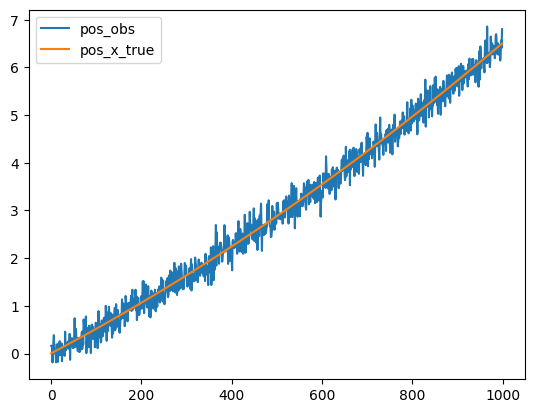

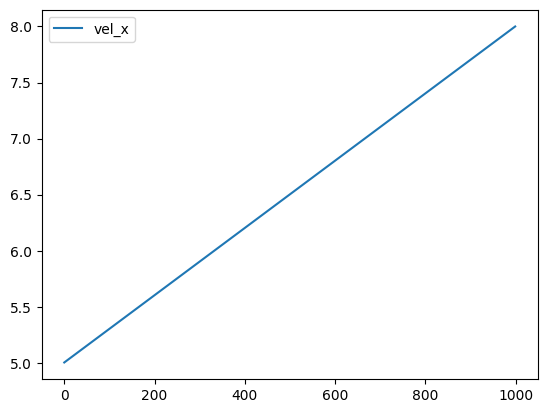

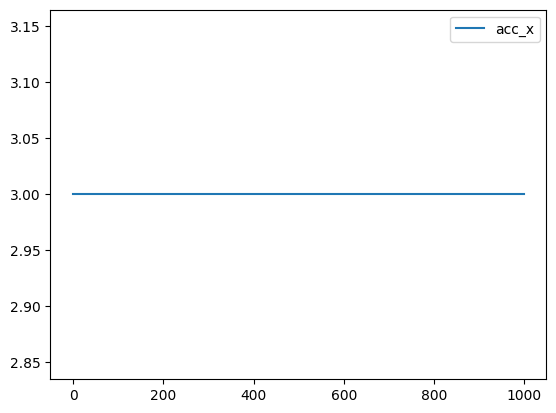

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Lets create the dynamical system
# Initialize variables
p0 = 0 # initial position
v0 = 5 # initial velocity
a  = 3 # acceleration
x = np.array([p0, v0, a]).reshape(3, 1) # initial state

assert(x.shape == (3,1))

dt = 0.001 # time difference between two measurements
H =  np.array([[1, dt, 0.5*(dt**2) ],[0, 1, dt],[0, 0, 1]]) # state transition matrix
F =  np.array([[1, 0, 0]]) # observation matrix

assert(H.shape == (3,3))
assert(F.shape == (1,3))


q_noise = np.array([0.2, 0.1, 0.2]).reshape(3, 1) # process noise
r_noise = np.array([0.01]).reshape(1, 1) # measurement noise

assert(q_noise.shape == (3,1))
assert(r_noise.shape == (1,1))

# Simulate the dynamical system for N-iterations
iterations = 1000
observation_dict = {
    "position_state_true" : [],
    "position_state_noisy" : [],
    "position_observation": [],
    "velocity" : [],
    "acceleration" : [],
}

for _ in range(iterations):
    x = H@x
    x_noisy = x + q_noise*np.random.randn(3,1)
    y = F@(x_noisy) + r_noise*np.random.randn(1,1)
    observation_dict["position_state_true"].append(x[0])
    observation_dict["position_state_noisy"].append(x_noisy[0])
    observation_dict["position_observation"].append(y[0])
    observation_dict["velocity"].append(x[1])
    observation_dict["acceleration"].append(x[2])

plt.figure()
plt.plot(observation_dict["position_observation"], label = "pos_obs")
plt.plot(observation_dict["position_state_true"], label = "pos_x_true")
plt.legend()

plt.figure()
plt.plot(observation_dict["velocity"], label = "vel_x")
plt.legend()

plt.figure()
plt.plot(observation_dict["acceleration"], label = "acc_x")
plt.legend()

## Lets Drive Kalman Filter Equations 
We will perform a Bayesian approach:

**GOAL:** To find $p(x_k | y^k)$ ; that is, estimate the state at time $k$ ($x_k$) using the observations until (and including) time $k$ ($y^k = y_0, y_1, y_2, \dots, y_k$).

$$
% \begin{align}
p(x_k | y_k) \propto p(y_k | x_k) p(x_k) \\
p(x_k | y_k) \propto p(y_k | x_k) \int_{x_{k-1}} p(x_k | x_{k-1}) p(x_{k-1}) dx_{k-1}\\
% \end{align}
$$

This is very structural and well formulaized approach; however, it is hard to follow the math using this approach (at least for me); therefore, we will use joint Gaussian properties to find the posterior.


#### Joint Gaussians
Assume that we have two variables, namely, $x$ and $y$ that are distributed as Gaussians.
$$ x \sim N(\mu_x, \Sigma_x)$$  
$$ y \sim N(\mu_y, \Sigma_y) $$

Let's define a variable $z$ which is the joint of $x$ and $y$. Then:

$$
z =
\begin{bmatrix}
x \\
y
\end{bmatrix}
\sim \mathcal{N} \left(
\begin{bmatrix}
\mu_x \\
\mu_y
\end{bmatrix},
\begin{bmatrix}
\Sigma_x & \Sigma_{xy} \\
\Sigma_{yx} & \Sigma_y
\end{bmatrix}
\right)
$$

Then the mean and the variance of the posterior $p(x|y)$ can be calculated as:

$$
E[x|y] = \mu_x + \Sigma_{xy}\Sigma_y^{-1}(y - \mu_y) \\ 
Var(x|y) = \Sigma_x - \Sigma_{xy}\Sigma_y^{-1}\Sigma_{yx}
$$


Lets turn back to our system and try to calculate the means and variances.

Prediction step
$$
\^{\mu}_{x_k} = H\mu_{x_{k-1}} \\
\^{\Sigma}_{x_k} = H\Sigma_{x_{k-1}}H^T + Q \\
\mu_{y_k} = F\mu_{x_k} \\
\Sigma_{y_k} = F\Sigma_{x_k}F^T + R
$$

Update Step
$$
\mu_{x_k} = \^{\mu}_{x_k} + \Sigma_{xy}\Sigma_y^{-1}(y - \mu_y) \\ 
\Sigma_{x_k} = \^{\Sigma}_{x_k} - \Sigma_{xy}\Sigma_y^{-1}\Sigma_{yx}
$$

Now we have all the equations we need. However, still this is not enough to build a KF. We need to do the followings:
- initiate $x_0 \sim \mathcal{N}(\mu_0, \Sigma_0)$
- calculate $\Sigma_{xy}$ and $\Sigma_y$
- initialize $Q$ and $R$ matrices. $Q$ should be initialized (or set) consistent with our model.

Let us calculate $\Sigma_y$:

$$
Var(y) = E[(y-\mu_y)(y-\mu_y)^T] \\
Var(y) = E[y^2 + \mu^2_y -2y\mu_y] \\
Var(y) = E[y^2] + \mu^2_y -2\mu_y E[y] \\
Var(y) = E[y^2] - \mu^2_y \\
E[y^2] = E[(Fx+v)(Fx+v)^T] \\
E[y^2] = E[Fxx^TF^T + Fxv^T + vx^TF^T + vv^T] \\
E[y^2] = FE[xx^T]F^T + FE[xv^T] + E[vx^T]F^t + E[vv^T] \\
E[y^2] = F(\Sigma_x + \^{\mu}_x\^{\mu}^T_x)F^T + 0 + 0 + R \\
E[y^2] = F\Sigma_xF^T + F\^{\mu}_x\^{\mu}^T_xF^T + R \\
Var(y) = F\Sigma_xF^T + F\^{\mu}_x\^{\mu}^T_xF^T + R - \mu^2_y \\
\mu_y = F\mu_x => \mu^2_y = F\mu_x\mu^T_xF^T \\
Var(y) = F\Sigma_xF^T + R \\
\Sigma_y = F\Sigma_xF^T + R
$$

OR, if you know that $v$ and $x$ are independent (which is the case) we can simply do the following:
$$
Var(y) = FVar(x)F^T + Var(v) \\
Var(y) = F\Sigma_xF^T + R \\
\Sigma_y = F\Sigma_xF^T + R
$$

Let us calculate $\Sigma_{xy}$:

$$
\Sigma_{xy} = E[(x -\mu_x)(y - \mu_y)^T] \\
\Sigma_{xy} = E[(x-\mu_x)(Fx + v - F\mu_x)^T] \\
\Sigma_{xy} = E[xx^TF^T + xv^T - x\mu^T_xF^T - \mu_xx^TF^T - \mu_xv^T + \mu_x\mu^T_xF^T] \\
\Sigma_{xy} = E[xx^T]F^T + 0 - \mu^2_xF^T - \mu^2_xF^T - 0 + \mu^2_xF^T \\
\Sigma_{xy} = \Sigma_xF^T + \mu^2_xF^T - \mu^2_xF^T \\
\Sigma_{xy} = \Sigma_xF^T
$$

Lastly, initializing $Q$ and $R$.
- R depends on the quality of the sensor. Assume our sensor is good enough, so we will initialize R as small
- Since our model is a constant acceleration model, any distrubance in accelaration will affect velocity and position differently; therefore, we can do the following:
$$
acc\_distrubance = a_0 \\
Q = diagonal\_mtx(0.5*dt^2*a_0,\ dt*a_0,\ a_0)
$$


Now we have all the ingredients that we require, so we can code the KF!!!!!


In [ ]:
# lets implement the prediction step
def prediction(mu_x, sigma_x, H, F, Q, R):
    mu_hat = H@mu_x
    sigma_hat = H@sigma_x@H.T + Q
    mu_y = F@mu_hat
    sigma_y = F@sigma_hat@F.T + R
    sigma_xy = sigma_hat@F.T
    return mu_hat, sigma_hat, mu_y, sigma_y, sigma_xy

# lets implement the update step
def update(mu_hat, sigma_hat, mu_y, sigma_y, sigma_xy, y):
    K = sigma_xy@np.linalg.inv(sigma_y)  # Lets call this the Kalman gain
    mu_x = mu_hat + K@(y - mu_y)
    sigma_x = sigma_hat - K@sigma_xy.T
    return mu_x, sigma_x, K

# Initialize x0
mu_x = np.array([0, 0, 0])
sigma_x = np.diag([10, 10, 10])
uncertainty_in_acc = 1
Q = np.diag([0.5*(dt**2)*uncertainty_in_acc, dt*uncertainty_in_acc, uncertainty_in_acc])  # Effect of process noise for position and velocity
R = np.array([0.01])  # Assume the sensor is good enough so keep the noise low


kalman_dict = {"position":[],
               "pos_cov":[],
               "vel_cov":[],
               "acc_cov":[],
               "gain_pos": [],
               "gain_vel": [],
               "gain_acc": []
            }
kalman_dict["position"].append(mu_x[0])
for pos in observation_dict["position_observation"]:
    mu_hat, sigma_hat, mu_y, sigma_y, sigma_xy = prediction(mu_x, sigma_x, H, F, Q, R)
    mu_x, sigma_x, K = update(mu_hat, sigma_hat, mu_y, sigma_y, sigma_xy, pos)

    kalman_dict["position"].append(mu_x[0])
    kalman_dict["pos_cov"].append(sigma_x[0, 0])
    kalman_dict["vel_cov"].append(sigma_x[1, 1])
    kalman_dict["acc_cov"].append(sigma_x[2, 2])
    kalman_dict["gain_pos"].append(K[0])
    kalman_dict["gain_vel"].append(K[1])
    kalman_dict["gain_acc"].append(K[2])



MSE BEFORE KF: 0.03911097471103327
MSE AFTER  KF: 0.0019401292423102206
Reduction in MSE: 95.03942497816882% 


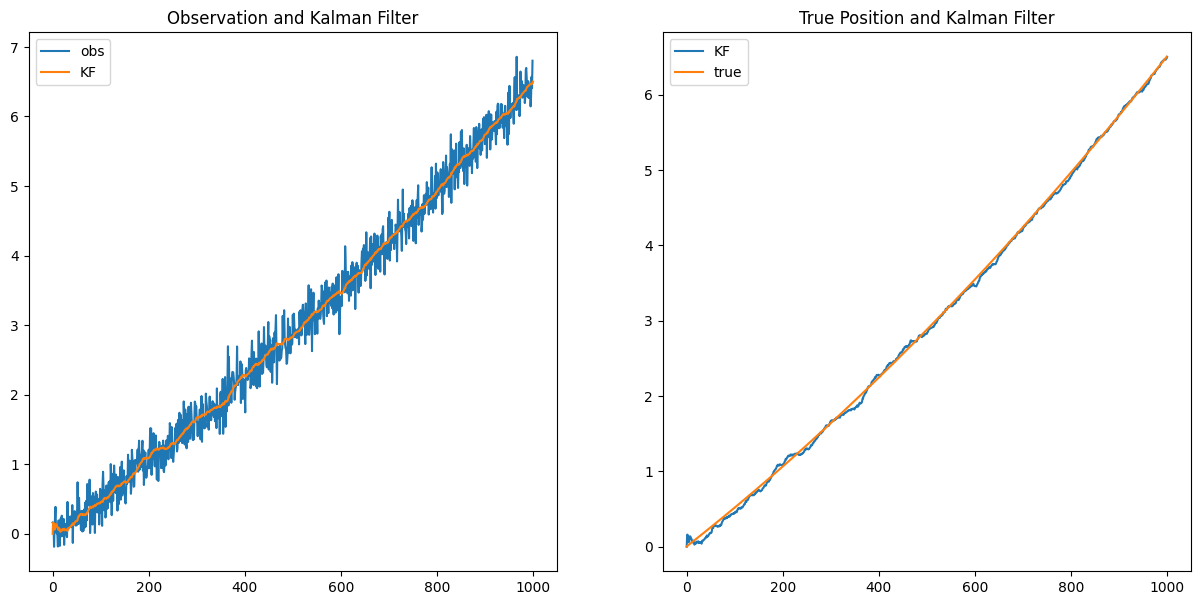

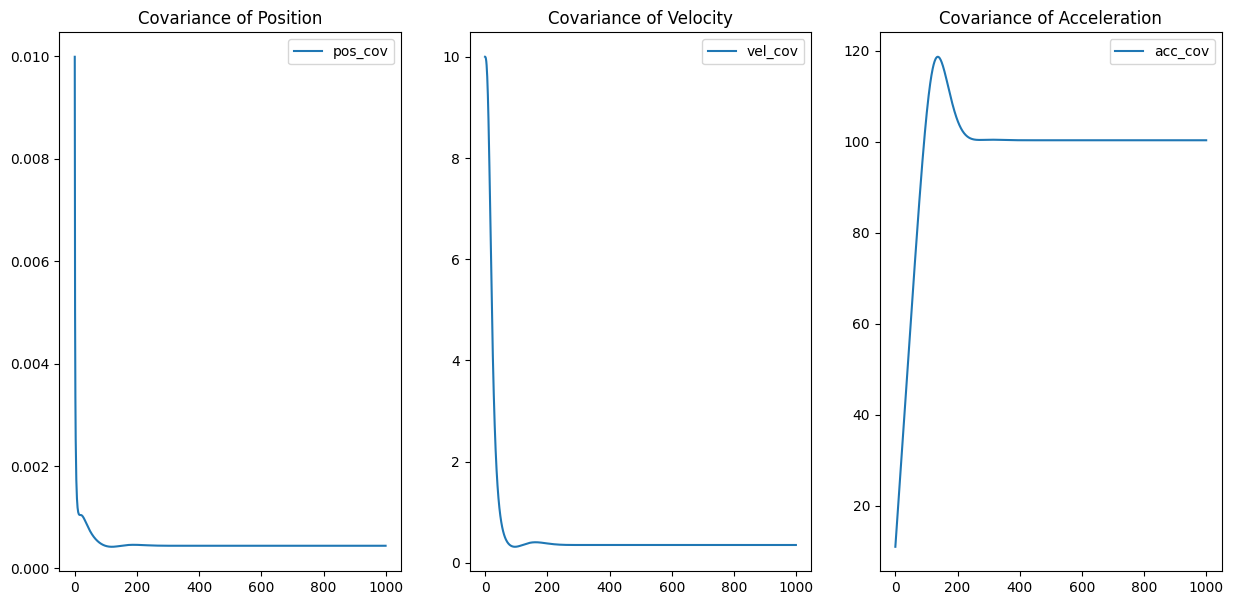

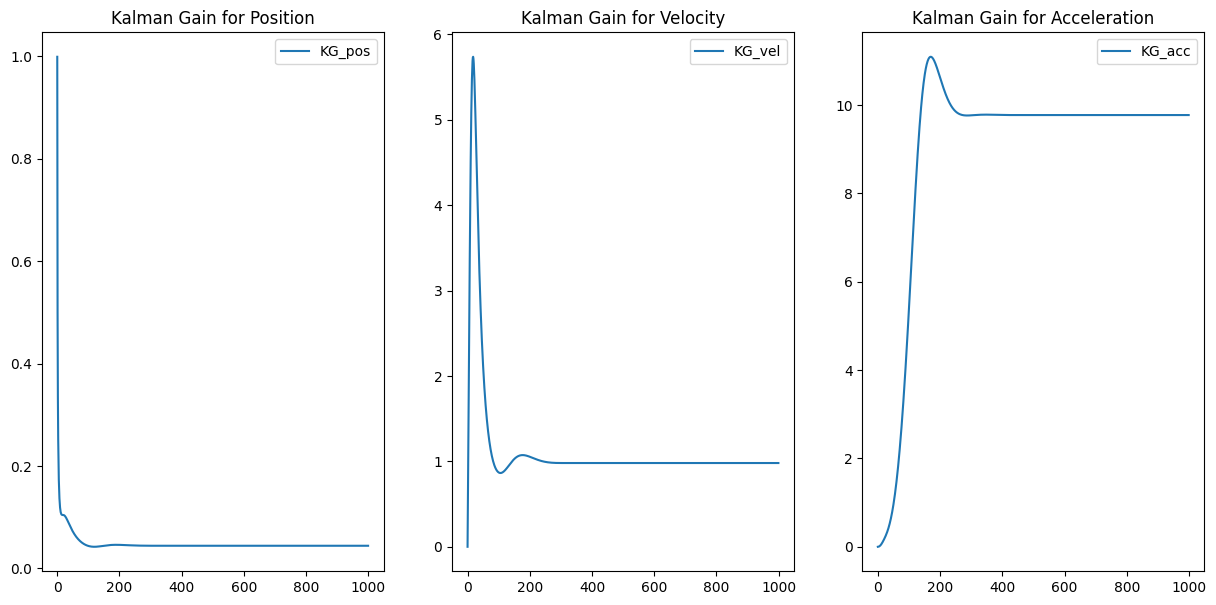

In [8]:
plt.figure(figsize=[15,7])
plt.subplot(1,2,1)
plt.title("Observation and Kalman Filter")
plt.plot(observation_dict["position_observation"], label="obs")
plt.plot(kalman_dict["position"], label="KF")
plt.legend()
plt.subplot(1,2,2)
plt.title("True Position and Kalman Filter")
plt.plot(kalman_dict["position"], label="KF")
plt.plot(observation_dict["position_state_true"], label="true")
plt.legend()

plt.figure(figsize=[15,7])
plt.subplot(1,3,1)
plt.title("Covariance of Position")
plt.plot(kalman_dict["pos_cov"], label="pos_cov")
plt.legend()
plt.subplot(1,3,2)
plt.title("Covariance of Velocity")
plt.plot(kalman_dict["vel_cov"], label="vel_cov")
plt.legend()
plt.subplot(1,3,3)
plt.title("Covariance of Acceleration")
plt.plot(kalman_dict["acc_cov"], label="acc_cov")
plt.legend()


plt.figure(figsize=[15,7])
plt.subplot(1,3,1)
plt.title("Kalman Gain for Position")
plt.plot(kalman_dict["gain_pos"], label="KG_pos")
plt.legend()
plt.subplot(1,3,2)
plt.title("Kalman Gain for Velocity")
plt.plot(kalman_dict["gain_vel"], label="KG_vel")
plt.legend()
plt.subplot(1,3,3)
plt.title("Kalman Gain for Acceleration")
plt.plot(kalman_dict["gain_acc"], label="KG_acc")
plt.legend()


def mse(data1, data2):
    return np.mean([(d1-d2)**2 for d1,d2 in zip(data1, data2)])

before_mse = mse(observation_dict['position_observation'], observation_dict['position_state_true'])
after_mse = mse(kalman_dict['position'], observation_dict['position_state_true'])
print(f"MSE BEFORE KF: {before_mse}")
print(f"MSE AFTER  KF: {after_mse}")
print(f"Reduction in MSE: {(1. - after_mse/before_mse)*100}% ")